In [8]:
import numpy as np
import pandas as pd 
import datetime
import ast
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Import original data files 
'vdonationc' contains all donation visits but information on genetic markers is present only in 'lastdon' so we will merge them.

In [2]:
data_last = pd.read_csv('../../data/lastdon.csv', low_memory=False)
data_all = pd.read_csv('../../data/vdonationc.csv', low_memory=False)
data_raw = data_all.merge(data_last[['vdonor', 'height', 'weight', 'smoking', 'bmi', 
                                     'snp_17_58358769', 'snp_6_32617727', 'snp_15_45095352',
                                     'snp_1_169549811', 'prs_anemia', 'prs_ferritin', 'prs_hemoglobin']], 
                          how='inner',
                          on='vdonor')
print(data_all.shape, data_raw.shape)

(5786320, 13) (645978, 24)


In [4]:
data_raw.columns

Index(['Unnamed: 0', 'vdonor', 'age', 'sex', 'aborh', 'zip', 'city', 'site',
       'date', 'Hb', 'status', 'donat_phleb', 'Hb_deferral', 'height',
       'weight', 'smoking', 'bmi', 'snp_17_58358769', 'snp_6_32617727',
       'snp_15_45095352', 'snp_1_169549811', 'prs_anemia', 'prs_ferritin',
       'prs_hemoglobin'],
      dtype='object')

Out of 5 786 320 total donations in vdonationc, we have genetic markers for 645 978. 

# Preprocess raw data
Drop some columns that are not needed: zip code, city, donation site and blood group. Blood group might be interesting to include, but factors have to be dummy-coded for SVMs. For now, drop it. Only keep successful whole-blood donations (donat_phleb == 'K') and Hb-deferred ones (Hb_deferral == 1 & donat_phleb == '\*') from the past 5 years (2016-2020). 

In [5]:
data = data_raw.copy().drop(columns=['Unnamed: 0', 'zip', 'city', 'site', 'aborh'])
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data = data.loc[(data.donat_phleb == 'K') | ((data.donat_phleb == '*') & (data.Hb_deferral == 1)), ]
print(data_raw.shape, data.shape)

data = data.drop(columns=['status','donat_phleb'])
#data.to_pickle('../../data/alldata.pkl')

data = data.loc[data.year > 2015, ]
#data.to_pickle('../../data/alldata_2016_2020.pkl')
print(data.shape)

(645978, 24) (601573, 21)
(201843, 19)


This leaves us with 201 843 donation attempts.

Add variables HbPrevn and DaystoPrevn for n between 1-5. 

In [8]:
def add_prev_hb_time(df, number):
    colnames = ['HbPrev'+str(number), 'DaystoPrev'+str(number)]
    df[colnames[0]] = df['Hb'].shift(number)
    df[colnames[1]] = (df['date'] - df['date'].shift(number)) / pd.Timedelta('1 day') 
    return df

data = data.dropna(axis=0)

df_1 = data.groupby('vdonor').apply(add_prev_hb_time, number=1)
print(datetime.datetime.now(), '1 done')
df_2 = df_1.groupby('vdonor').apply(add_prev_hb_time, number=2)
print(datetime.datetime.now(), '2 done')
df_3 = df_2.groupby('vdonor').apply(add_prev_hb_time, number=3)
print(datetime.datetime.now(), '3 done')
df_4 = df_3.groupby('vdonor').apply(add_prev_hb_time, number=4)
print(datetime.datetime.now(), '4 done')
df_5 = df_4.groupby('vdonor').apply(add_prev_hb_time, number=5)
print(datetime.datetime.now(), '5 done')
df_5.head()

df_5.to_pickle('../../data/df_2016_2020.pkl')

2022-06-10 08:06:47.623657 1 done
2022-06-10 08:07:34.105506 2 done
2022-06-10 08:08:20.699617 3 done
2022-06-10 08:09:06.865591 4 done
2022-06-10 08:09:52.173233 5 done


# Checking pre-processed data

In [7]:
df = pd.read_pickle('../../data/df_2016_2020.pkl')
df.describe()

,age,Hb,Hb_deferral,height,weight,bmi,snp_17_58358769,snp_6_32617727,snp_15_45095352,snp_1_169549811,prs_anemia,prs_ferritin,prs_hemoglobin,year,month,HbPrev1,DaystoPrev1,HbPrev2,DaystoPrev2,HbPrev3,DaystoPrev3,HbPrev4,DaystoPrev4,HbPrev5,DaystoPrev5
count,201824.000000,201824.000000,201824.000000,201824.000000,201824.000000,201824.000000,201824.000000,201824.000000,201824.000000,201824.000000,2.018240e+05,2.018240e+05,2.018240e+05,201824.000000,201824.000000,173801.000000,173801.000000,147363.000000,147363.000000,123369.000000,123369.000000,102175.000000,102175.000000,83759.000000,83759.000000
mean,45.669028,147.499569,0.027142,173.074109,81.227911,27.038312,0.016787,0.893184,0.128161,0.041962,-1.948470e-08,1.507380e-08,4.263139e-08,2017.761020,6.271851,147.551809,157.428122,147.642278,293.187449,147.805989,412.044695,148.017343,517.297088,148.265822,611.205841
std,14.590492,12.588103,0.162499,9.051934,16.280499,4.629288,0.128781,0.704122,0.348806,0.203447,1.239539e-06,1.856788e-06,4.549941e-06,1.207365,3.491396,12.569541,121.281980,12.541842,165.886567,12.505999,192.537358,12.445274,208.724071,12.379089,218.817803
min,18.000000,86.000000,0.000000,138.000000,49.000000,15.319690,0.000000,0.000000,0.000000,0.000000,-5.205663e-06,-7.419362e-06,-1.667440e-05,2016.000000,1.000000,86.000000,1.000000,86.000000,59.000000,86.000000,91.000000,86.000000,153.000000,92.000000,224.000000
25%,32.000000,139.000000,0.000000,166.000000,70.000000,23.875115,0.000000,0.000000,0.000000,0.000000,-8.569331e-07,-1.236121e-06,-3.073347e-06,2017.000000,3.000000,139.000000,92.000000,139.000000,189.000000,139.000000,282.000000,139.000000,371.000000,140.000000,452.000000
50%,48.000000,147.000000,0.000000,173.000000,80.000000,26.250725,0.000000,1.000000,0.000000,0.000000,-1.964410e-08,4.710500e-09,1.946190e-08,2018.000000,6.000000,147.000000,115.000000,147.000000,242.000000,147.000000,360.000000,148.000000,469.000000,148.000000,568.000000
75%,58.000000,156.000000,0.000000,180.000000,90.000000,29.402435,0.000000,1.000000,0.000000,0.000000,8.153091e-07,1.255356e-06,3.153662e-06,2019.000000,9.000000,156.000000,177.000000,156.000000,347.000000,156.000000,490.000000,156.000000,617.000000,157.000000,729.000000
max,71.000000,196.000000,1.000000,210.000000,190.000000,65.192744,2.000000,2.000000,2.000000,2.000000,5.440998e-06,8.449034e-06,1.759645e-05,2020.000000,12.000000,196.000000,1421.000000,196.000000,1552.000000,195.000000,1569.000000,195.000000,1546.000000,195.000000,1561.000000


Min, max and mean for most variables look sensible. However the minimum value for several DaystoPrevn variables is very low, so we investigate this. From the Veripalvelu website: *The minimum interval between blood donations is 91 days for women and 61 days for men.* Values smaller than this can occur if the previous visit was a deferral, however. This is the case for almost all these observations. There are a few (<100) observations that have DaystoPrevn variables smaller than the minimum donation interval, but they do appear to be valid donations. We leave them in the dataset.

A look at the distribution of number of donation attempts per donor:

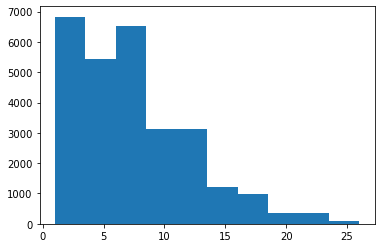

In [10]:
dcounts = df.vdonor.value_counts()

plt.hist(dcounts)
plt.show()

## Marginal distributions of variables per SVM

We want to describe the distributions of all variables in the data set separately for women and men, and separately for the five models SVM-1 through SVM-5. 

In [11]:
df_m = df.loc[df['sex'] == 'Men', ]

for nback in range(1, 6):
    varname = 'HbPrev' + str(nback)
    df_sub = df_m.dropna(subset=['HbPrev'+str(nback)])
    print(nback, 'donations back')
    print(df_sub.loc[:, ['vdonor', 'year', 'sex', 'age', 'month', 'smoking', 'height', 'weight', 'bmi',
                         'snp_17_58358769', 'snp_6_32617727', 'snp_15_45095352', 'snp_1_169549811', 'prs_anemia', 'prs_ferritin',
                         'prs_hemoglobin', 'HbPrev1', 'DaystoPrev1', 'HbPrev2', 'DaystoPrev2','HbPrev3', 'DaystoPrev3',
                         'HbPrev4', 'DaystoPrev4', 'HbPrev5', 'DaystoPrev5']].describe())

1 donations back
               year           age         month        height        weight  \
count  89326.000000  89326.000000  89326.000000  89326.000000  89326.000000   
mean    2017.907731     48.753297      6.480196    179.635828     88.285180   
std        1.162486     13.589390      3.485412      6.497869     14.823978   
min     2016.000000     18.000000      1.000000    149.000000     50.000000   
25%     2017.000000     38.000000      3.000000    175.000000     78.000000   
50%     2018.000000     52.000000      6.000000    180.000000     86.000000   
75%     2019.000000     60.000000     10.000000    184.000000     96.000000   
max     2020.000000     71.000000     12.000000    210.000000    190.000000   

                bmi  snp_17_58358769  snp_6_32617727  snp_15_45095352  \
count  89326.000000     89326.000000    89326.000000     89326.000000   
mean      27.328907         0.017184        0.905727         0.125529   
std        4.176700         0.129958        0.706652

               year           age         month        height        weight  \
count  58979.000000  58979.000000  58979.000000  58979.000000  58979.000000   
mean    2018.328405     50.506299      6.408044    179.540074     88.357466   
std        0.967162     13.153224      3.561177      6.464746     14.823914   
min     2016.000000     18.000000      1.000000    149.000000     50.000000   
25%     2018.000000     42.000000      3.000000    175.000000     78.000000   
50%     2018.000000     54.000000      6.000000    180.000000     86.000000   
75%     2019.000000     61.000000     10.000000    184.000000     96.000000   
max     2020.000000     71.000000     12.000000    210.000000    187.000000   

                bmi  snp_17_58358769  snp_6_32617727  snp_15_45095352  \
count  58979.000000     58979.000000    58979.000000     58979.000000   
mean      27.378777         0.015548        0.905068         0.122298   
std        4.170662         0.123719        0.706441         0.344188

In [12]:
df_f = df.loc[df['sex'] == 'Women', ]

for nback in range(1, 6):
    varname = 'HbPrev' + str(nback)
    df_sub = df_f.dropna(subset=['HbPrev'+str(nback)])
    print(nback, 'donations back')
    print(df_sub.loc[:, ['vdonor', 'year', 'sex', 'age', 'month', 'smoking', 'height', 'weight', 'bmi',
                         'snp_17_58358769', 'snp_6_32617727', 'snp_15_45095352', 'snp_1_169549811', 'prs_anemia', 'prs_ferritin',
                         'prs_hemoglobin', 'HbPrev1', 'DaystoPrev1', 'HbPrev2', 'DaystoPrev2','HbPrev3', 'DaystoPrev3',
                         'HbPrev4', 'DaystoPrev4', 'HbPrev5', 'DaystoPrev5']].describe())

1 donations back
               year           age         month        height        weight  \
count  84475.000000  84475.000000  84475.000000  84475.000000  84475.000000   
mean    2017.994673     43.992897      6.471074    166.482048     74.284037   
std        1.120251     14.964717      3.476580      5.901633     14.506719   
min     2016.000000     18.000000      1.000000    138.000000     49.000000   
25%     2017.000000     29.000000      3.000000    162.000000     64.000000   
50%     2018.000000     46.000000      6.000000    166.000000     71.000000   
75%     2019.000000     57.000000     10.000000    170.000000     82.000000   
max     2020.000000     70.000000     12.000000    198.000000    172.000000   

                bmi  snp_17_58358769  snp_6_32617727  snp_15_45095352  \
count  84475.000000     84475.000000    84475.000000     84475.000000   
mean      26.795751         0.015567        0.879361         0.129790   
std        5.009264         0.124365        0.701295

               year           age         month        height        weight  \
count  33198.000000  33198.000000  33198.000000  33198.000000  33198.000000   
mean    2018.673384     47.820592      6.425297    166.366528     74.663112   
std        0.812913     14.447841      3.582280      5.882038     14.343788   
min     2017.000000     19.000000      1.000000    138.000000     50.000000   
25%     2018.000000     36.000000      3.000000    162.000000     65.000000   
50%     2019.000000     51.000000      6.000000    166.000000     72.000000   
75%     2019.000000     60.000000     10.000000    170.000000     82.000000   
max     2020.000000     70.000000     12.000000    193.000000    170.000000   

                bmi  snp_17_58358769  snp_6_32617727  snp_15_45095352  \
count  33198.000000     33198.000000    33198.000000     33198.000000   
mean      26.969756         0.013314        0.871830         0.128682   
std        4.950788         0.114880        0.701829         0.347132

# Scaled based on training data

We need to scale all explanatory variables before doing anything with the SVM. We use the StandardScaler option in the sk-learn package, which makes all variables have a mean of zero and variance of one. We save the scalers for later use when we change time-related variables. Scalers are fitted using only the training data and then used to transform both training and test data.

Test data will be the last year of donations (1 May 2019 - 31 April 2020) and training data everything before that.

In [13]:
df = pd.read_pickle('../../data/df_2016_2020.pkl')

In [11]:
var = ['vdonor', 'date', 'sex', 'year', 'age', 'month', 'smoking', 'height', 'weight', 'bmi', 
       'snp_17_58358769', 'snp_6_32617727', 'snp_15_45095352', 'snp_1_169549811', 'prs_anemia', 'prs_ferritin',
       'prs_hemoglobin']
for n in range(1, 6):
    var.extend(['HbPrev'+str(n), 'DaystoPrev'+str(n)])
var.append('Hb_deferral')

df['smoking'] = df['smoking'].astype(int)

train_men = df.loc[(df.sex == 'Men') & (df.date <= '2019-05-01'), var]
train_men = train_men[train_men.columns[4:]]
train_women = df.loc[(df.sex == 'Women') & (df.date <= '2019-05-01'), var]
train_women = train_women[train_women.columns[4:]]

test_men = df.loc[(df.sex == 'Men') & (df.date > '2019-05-01'), var]
test_men = test_men[test_men.columns[4:]]
test_women = df.loc[(df.sex == 'Women') & (df.date > '2019-05-01'), var]
test_women = test_women[test_women.columns[4:]]

In [12]:
for nback in range(1, 6):
    var = ['age', 'month', 'smoking', 'height', 'weight', 'bmi', 
           'snp_17_58358769', 'snp_6_32617727', 'snp_15_45095352', 'snp_1_169549811', 'prs_anemia', 'prs_ferritin',
           'prs_hemoglobin']
    for n in range(1, nback+1):
        var.extend(['HbPrev'+str(n), 'DaystoPrev'+str(n)])
    var.append('Hb_deferral')
    
    train_men_sub = train_men[var].dropna()
    train_women_sub = train_women[var].dropna()
    test_men_sub = test_men[var].dropna()
    test_women_sub = test_women[var].dropna()
    
    scaler_men = StandardScaler()
    scaler_women = StandardScaler()
    scaler_men.fit(train_men_sub[train_men_sub.columns[:-1]])
    scaler_women.fit(train_women_sub[train_men_sub.columns[:-1]])
    
    train_men_sub[train_men_sub.columns[:-1]] = scaler_men.transform(train_men_sub[train_men_sub.columns[:-1]])
    train_women_sub[train_women_sub.columns[:-1]] = scaler_women.transform(train_women_sub[train_women_sub.columns[:-1]])
    test_men_sub[test_men_sub.columns[:-1]] = scaler_men.transform(test_men_sub[test_men_sub.columns[:-1]])
    test_women_sub[test_women_sub.columns[:-1]] = scaler_women.transform(test_women_sub[test_women_sub.columns[:-1]])
    
    pickle.dump(scaler_men, open('../results/scalers/men_'+str(nback)+'.pkl', 'wb'))
    pickle.dump(scaler_women, open('../results/scalers/women_'+str(nback)+'.pkl', 'wb'))
    
    train_men_sub.to_pickle('../../data/scaled/men_'+str(nback)+'_train.pkl')
    train_women_sub.to_pickle('../../data/scaled/women_'+str(nback)+'_train.pkl')
    test_men_sub.to_pickle('../../data/scaled/men_'+str(nback)+'_test.pkl')
    test_women_sub.to_pickle('../../data/scaled/women_'+str(nback)+'_test.pkl')

# Limited variables ('onlyhb'), scaled on training data
To draw comparisons with results on the Dutch data, we also fit the model on data only containing the variables present in the Dutch data. This has the same result as removing those variables from the scaled data created above.

In [14]:
df = pd.read_pickle('../../data/df_2016_2020.pkl')

In [45]:
var = ['vdonor', 'date', 'sex', 'year', 'age', 'month']
for n in range(1, 6):
    var.extend(['HbPrev'+str(n), 'DaystoPrev'+str(n)])
var.append('Hb_deferral')

train_men = df.loc[(df.sex == 'Men') & (df.date <= '2019-05-01'), var]
train_men = train_men[train_men.columns[4:]]
train_women = df.loc[(df.sex == 'Women') & (df.date <= '2019-05-01'), var]
train_women = train_women[train_women.columns[4:]]

test_men = df.loc[(df.sex == 'Men') & (df.date > '2019-05-01'), var]
test_men = test_men[test_men.columns[4:]]
test_women = df.loc[(df.sex == 'Women') & (df.date > '2019-05-01'), var]
test_women = test_women[test_women.columns[4:]]

In [47]:
for nback in range(1, 6):
    var = ['age', 'month']
    for n in range(1, nback+1):
        var.extend(['HbPrev'+str(n), 'DaystoPrev'+str(n)])
    var.append('Hb_deferral')
    
    train_men_sub = train_men[var].dropna()
    train_women_sub = train_women[var].dropna()
    test_men_sub = test_men[var].dropna()
    test_women_sub = test_women[var].dropna()
    
    scaler_men = StandardScaler()
    scaler_women = StandardScaler()
    scaler_men.fit(train_men_sub[train_men_sub.columns[:-1]])
    scaler_women.fit(train_women_sub[train_men_sub.columns[:-1]])
    
    pickle.dump(scaler_men, open('../results/scalers_onlyhb/men_'+str(nback)+'.pkl', 'wb'))
    pickle.dump(scaler_women, open('../results/scalers_onlyhb/women_'+str(nback)+'.pkl', 'wb'))
    
    train_men_sub[train_men_sub.columns[:-1]] = scaler_men.transform(train_men_sub[train_men_sub.columns[:-1]])
    train_women_sub[train_women_sub.columns[:-1]] = scaler_women.transform(train_women_sub[train_women_sub.columns[:-1]])
    test_men_sub[test_men_sub.columns[:-1]] = scaler_men.transform(test_men_sub[test_men_sub.columns[:-1]])
    test_women_sub[test_women_sub.columns[:-1]] = scaler_women.transform(test_women_sub[test_women_sub.columns[:-1]])
    
    train_men_sub.to_pickle('../../data/scaled_onlyhb/men_'+str(nback)+'_train.pkl')
    train_women_sub.to_pickle('../../data/scaled_onlyhb/women_'+str(nback)+'_train.pkl')
    test_men_sub.to_pickle('../../data/scaled_onlyhb/men_'+str(nback)+'_test.pkl')
    test_women_sub.to_pickle('../../data/scaled_onlyhb/women_'+str(nback)+'_test.pkl')